# F20DL Lab 11

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import tensorflow as tf

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=10)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)

In [2]:
# Load the dataset into numpy arrays
X = np.load("./datasets/smiley_X_new.npy")
y = np.load("./datasets/smiley_Y_new.npy")

In [3]:
# X is a list of all images. Images are represented as columns of pixel values.
# To get pixel (r, c) of image i, use X[i][r-1][c-1][0]

# X[0] returns columns of pixel values representing the 1st image.
# X[0][2][6][0] returns the value of the pixel in the 3rd row and 7th column of the 1st image (r=3, c=7).
# y[0] returns the label for the 1st image. (0 = happy, 1 = sad)

In [4]:
class_names = ["happy", "sad"]

In [5]:
# Shows smiley as an image. 'smiley' should be an element in 'X'
def show_smiley(smiley):
    plt.figure(figsize=(1,1))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(smiley, cmap="Greys")

In [6]:
# Reference: https://stackoverflow.com/a/43957826
def reset_weights(model, weights):
    model.set_weights(weights)

In [7]:
from sklearn.model_selection import KFold

def cross_val(model, model_weights, data, labels, k=10):
    k_fold_splitter = KFold(n_splits=k)
    scores = []
    
    i = 1
    for train_i, test_i in k_fold_splitter.split(data):
        # Select data for current fold
        train_data, train_labels = data[train_i], labels[train_i]
        test_data, test_labels = data[test_i], labels[test_i]
        
        reset_weights(model, model_weights)
        
        print("Training and testing fold %i..." % i)
        
        # Get and save accuracy of current fold
        model.fit(train_data, train_labels, epochs=5, verbose=0, batch_size=100)
        acc = model.evaluate(test_data, test_labels, verbose=0)[1]    # Select accuracy only
        scores.append(acc)
        i+=1
    
    return np.asarray(scores)

In [8]:
from tensorflow.keras.metrics import BinaryAccuracy, TruePositives, FalsePositives, TrueNegatives, FalseNegatives, \
    SensitivityAtSpecificity, SpecificityAtSensitivity, Precision, Recall, AUC

metrics_at_compile = [BinaryAccuracy(), 
                      TruePositives(), 
                      FalsePositives(), 
                      TrueNegatives(), 
                      FalseNegatives(),
                      SensitivityAtSpecificity(0), 
                      SpecificityAtSensitivity(0), 
                      Precision(), 
                      Recall(), 
                      AUC()]

metric_labels = ["Accuracy", "TP", "FP", "TN", "FN", "Sensitivity", "Specificity", "Precision", "Recall", "ROC Area"]
metric_list = []

In [9]:
def format_metrics(metrics):
    for i, x in enumerate(metrics):
        if i in [2, 3, 4, 5]:
            metrics[i] = int(x)
            continue
        
        metrics[i] = round(x, 3)
    
    return metrics

## Convolutional Neural Networks

### CNN 0

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
print("Training samples: %i, Testing samples: %i" % (X_train.shape[0], X_test.shape[0]))

Training samples: 6384, Testing samples: 2736


In [11]:
cnn0 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (2,2), activation='relu', input_shape=(9, 9, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
cnn0_weights = cnn0.get_weights()

cnn0.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics_at_compile)
cnn0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 8, 64)          320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 64)          16448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8

In [12]:
cnn0.fit(X_train, y_train, epochs=5)

Epoch 1/5
200/200 [==============================] - 6s 20ms/step - loss: 0.2897 - binary_accuracy: 0.8670 - true_positives: 2674.0000 - false_positives: 355.0000 - true_negatives: 2861.0000 - false_negatives: 494.0000 - sensitivity_at_specificity: 1.0000 - specificity_at_sensitivity: 1.0000 - precision: 0.8828 - recall: 0.8441 - auc: 0.9532
Epoch 2/5
200/200 [==============================] - 4s 22ms/step - loss: 0.1038 - binary_accuracy: 0.9328 - true_positives: 2944.0000 - false_positives: 205.0000 - true_negatives: 3011.0000 - false_negatives: 224.0000 - sensitivity_at_specificity: 1.0000 - specificity_at_sensitivity: 1.0000 - precision: 0.9349 - recall: 0.9293 - auc: 0.9909
Epoch 3/5
200/200 [==============================] - 4s 21ms/step - loss: 0.0969 - binary_accuracy: 0.9355 - true_positives: 2966.0000 - false_positives: 210.0000 - true_negatives: 3006.0000 - false_negatives: 202.0000 - sensitivity_at_specificity: 1.0000 - specificity_at_sensitivity: 1.0000 - precision: 0.9339

In [13]:
metrics = cnn0.evaluate(X_test,  y_test, verbose=0)
metrics = format_metrics(metrics)
metric_list.append(metrics[1:])
print('\nTest accuracy:', metrics[1])


Test accuracy: 0.929


In [14]:
y_pred0 = cnn0.predict(X_test)

86/86 [==============================] - 0s 1ms/step


Prediction:  happy


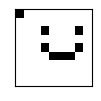

In [15]:
# Prediction for first testing image
print("Prediction: ", class_names[np.argmax(y_pred0[0])])
show_smiley(X_test[0])

In [16]:
# Reference: https://stackoverflow.com/a/43957826
def reset_weights(model, weights):
    model.set_weights(weights)

In [17]:
cross_val_scores = cross_val(cnn0, cnn0_weights, X, y, k=10)
print("Cross validation scores: ", cross_val_scores.round(3))
print("Mean score: ", cross_val_scores.mean().round(3))

Training and testing fold 1...
Training and testing fold 2...
Training and testing fold 3...
Training and testing fold 4...
Training and testing fold 5...
Training and testing fold 6...
Training and testing fold 7...
Training and testing fold 8...
Training and testing fold 9...
Training and testing fold 10...
Cross validation scores:  [0.912 0.934 0.932 0.941 0.924 0.935 0.918 0.933 0.95  0.941]
Mean score:  0.932


## Experimenting with Different Architectures

### CNN 1 - Batach Size and Validation Split

#### Batch Size = 100, Validation Split = 0.3

In [18]:
reset_weights(cnn0, cnn0_weights)

cnn0.compile(optimizer='adam', loss='binary_crossentropy', metrics=[BinaryAccuracy()])
cnn0.fit(x=X_train, y=y_train, epochs=5, batch_size=100, validation_split=0.3)

metrics = cnn0.evaluate(X_test, y_test, verbose=0)
metrics = format_metrics(metrics)
print('\nTest accuracy:', metrics[1])

Epoch 1/5
45/45 [==============================] - 3s 46ms/step - loss: 0.5904 - binary_accuracy: 0.7162 - val_loss: 0.3887 - val_binary_accuracy: 0.9087
Epoch 2/5
45/45 [==============================] - 2s 41ms/step - loss: 0.2379 - binary_accuracy: 0.9064 - val_loss: 0.1351 - val_binary_accuracy: 0.9358
Epoch 3/5
45/45 [==============================] - 1s 30ms/step - loss: 0.1193 - binary_accuracy: 0.9333 - val_loss: 0.1032 - val_binary_accuracy: 0.9337
Epoch 4/5
45/45 [==============================] - 2s 43ms/step - loss: 0.1086 - binary_accuracy: 0.9322 - val_loss: 0.1187 - val_binary_accuracy: 0.9322
Epoch 5/5
45/45 [==============================] - 2s 44ms/step - loss: 0.1057 - binary_accuracy: 0.9367 - val_loss: 0.0953 - val_binary_accuracy: 0.9342

Test accuracy: 0.927


#### Batch Size = 64, Validation Split = 0.3

In [19]:
reset_weights(cnn0, cnn0_weights)

cnn0.compile(optimizer='adam', loss='binary_crossentropy', metrics=[BinaryAccuracy()])
cnn0.fit(x=X_train, y=y_train, epochs=5, batch_size=64, validation_split=0.3)

metrics = cnn0.evaluate(X_test, y_test, verbose=0)
metrics = format_metrics(metrics)
print('\nTest accuracy:', metrics[1])

Epoch 1/5
70/70 [==============================] - 2s 16ms/step - loss: 0.5035 - binary_accuracy: 0.7704 - val_loss: 0.2168 - val_binary_accuracy: 0.8867
Epoch 2/5
70/70 [==============================] - 2s 22ms/step - loss: 0.1484 - binary_accuracy: 0.9237 - val_loss: 0.1063 - val_binary_accuracy: 0.9332
Epoch 3/5
70/70 [==============================] - 2s 29ms/step - loss: 0.1082 - binary_accuracy: 0.9326 - val_loss: 0.0995 - val_binary_accuracy: 0.9311
Epoch 4/5
70/70 [==============================] - 2s 29ms/step - loss: 0.0996 - binary_accuracy: 0.9355 - val_loss: 0.0959 - val_binary_accuracy: 0.9363
Epoch 5/5
70/70 [==============================] - 1s 20ms/step - loss: 0.0995 - binary_accuracy: 0.9322 - val_loss: 0.0944 - val_binary_accuracy: 0.9322

Test accuracy: 0.928


#### Batch Size = 64, Validation Split = 0.5

In [20]:
reset_weights(cnn0, cnn0_weights)

cnn0.compile(optimizer='adam', loss='binary_crossentropy', metrics=[BinaryAccuracy()])
cnn0.fit(x=X_train, y=y_train, epochs=5, batch_size=64, validation_split=0.5)

metrics = cnn0.evaluate(X_test, y_test, verbose=0)
metrics = format_metrics(metrics)
print('\nTest accuracy:', metrics[1])

Epoch 1/5
50/50 [==============================] - 2s 30ms/step - loss: 0.5721 - binary_accuracy: 0.7644 - val_loss: 0.3505 - val_binary_accuracy: 0.8875
Epoch 2/5
50/50 [==============================] - 2s 36ms/step - loss: 0.2096 - binary_accuracy: 0.9088 - val_loss: 0.1367 - val_binary_accuracy: 0.9311
Epoch 3/5
50/50 [==============================] - 1s 23ms/step - loss: 0.1185 - binary_accuracy: 0.9367 - val_loss: 0.1227 - val_binary_accuracy: 0.9320
Epoch 4/5
50/50 [==============================] - 1s 27ms/step - loss: 0.1092 - binary_accuracy: 0.9333 - val_loss: 0.1099 - val_binary_accuracy: 0.9320
Epoch 5/5
50/50 [==============================] - 1s 25ms/step - loss: 0.0997 - binary_accuracy: 0.9352 - val_loss: 0.1032 - val_binary_accuracy: 0.9314

Test accuracy: 0.931


#### Batch Size = 100, Validation Split = 0.5

In [21]:
reset_weights(cnn0, cnn0_weights)

cnn0.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics_at_compile)
cnn0.fit(x=X_train, y=y_train, epochs=5, batch_size=100, validation_split=0.5)

metrics = cnn0.evaluate(X_test, y_test, verbose=0)
metrics = format_metrics(metrics)
metric_list.append(metrics[1:])
print('\nTest accuracy:', metrics[1])

Epoch 1/5
32/32 [==============================] - 4s 47ms/step - loss: 0.6353 - binary_accuracy: 0.7641 - true_positives: 1494.0000 - false_positives: 421.0000 - true_negatives: 1642.0000 - false_negatives: 547.0000 - sensitivity_at_specificity: 1.0000 - specificity_at_sensitivity: 1.0000 - precision: 0.7802 - recall: 0.7320 - auc: 0.8587 - val_loss: 0.5298 - val_binary_accuracy: 0.8080 - val_true_positives: 1015.0000 - val_false_positives: 47.0000 - val_true_negatives: 1564.0000 - val_false_negatives: 566.0000 - val_sensitivity_at_specificity: 1.0000 - val_specificity_at_sensitivity: 1.0000 - val_precision: 0.9557 - val_recall: 0.6420 - val_auc: 0.9312
Epoch 2/5
32/32 [==============================] - 3s 80ms/step - loss: 0.3588 - binary_accuracy: 0.8847 - true_positives: 1305.0000 - false_positives: 86.0000 - true_negatives: 1519.0000 - false_negatives: 282.0000 - sensitivity_at_specificity: 1.0000 - specificity_at_sensitivity: 1.0000 - precision: 0.9382 - recall: 0.8223 - auc: 0.9

---

### CNN 2 - Learning Rate and Momentum

#### Optimiser = SGD (Defaults: Learning Rate = 0.001, Momentum = 0)

In [22]:
reset_weights(cnn0, cnn0_weights)

cnn0.compile(optimizer=tf.keras.optimizers.SGD(), 
             loss="binary_crossentropy", 
             metrics=[BinaryAccuracy()])
cnn0.fit(X_train, y_train, epochs=5)

metrics = cnn0.evaluate(X_test, y_test, verbose=0)
metrics = format_metrics(metrics)
print('\nTest accuracy:', metrics[1])

Epoch 1/5
200/200 [==============================] - 5s 21ms/step - loss: 0.6877 - binary_accuracy: 0.6383
Epoch 2/5
200/200 [==============================] - 4s 20ms/step - loss: 0.6796 - binary_accuracy: 0.6725
Epoch 3/5
200/200 [==============================] - 4s 21ms/step - loss: 0.6699 - binary_accuracy: 0.7049
Epoch 4/5
200/200 [==============================] - 4s 20ms/step - loss: 0.6561 - binary_accuracy: 0.7079
Epoch 5/5
200/200 [==============================] - 4s 19ms/step - loss: 0.6362 - binary_accuracy: 0.7179

Test accuracy: 0.704


#### Optimiser = SGD, Learning Rate = 0.01, Momentum = 0.9

In [23]:
reset_weights(cnn0, cnn0_weights)

cnn0.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), 
             loss="binary_crossentropy", 
             metrics=[BinaryAccuracy()])
cnn0.fit(X_train, y_train, epochs=5)

metrics = cnn0.evaluate(X_test, y_test, verbose=0)
metrics = format_metrics(metrics)
print('\nTest accuracy:', metrics[1])

Epoch 1/5
200/200 [==============================] - 1s 2ms/step - loss: 0.6195 - binary_accuracy: 0.6947
Epoch 2/5
200/200 [==============================] - 0s 2ms/step - loss: 0.1975 - binary_accuracy: 0.9162
Epoch 3/5
200/200 [==============================] - 1s 3ms/step - loss: 0.1089 - binary_accuracy: 0.9358
Epoch 4/5
200/200 [==============================] - 1s 3ms/step - loss: 0.1017 - binary_accuracy: 0.9309
Epoch 5/5
200/200 [==============================] - 3s 16ms/step - loss: 0.0999 - binary_accuracy: 0.9314

Test accuracy: 0.933


#### Optimiser = SGD, Learning Rate = 0.1, Momentum = 0.9

In [24]:
reset_weights(cnn0, cnn0_weights)

cnn0.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9), 
             loss="binary_crossentropy", 
             metrics=metrics_at_compile)
cnn0.fit(X_train, y_train, epochs=5)

metrics = cnn0.evaluate(X_test, y_test, verbose=0)
metrics = format_metrics(metrics)
metric_list.append(metrics[1:])
print('\nTest accuracy:', metrics[1])

Epoch 1/5
200/200 [==============================] - 5s 8ms/step - loss: 0.2379 - binary_accuracy: 0.8826 - true_positives: 4020.0000 - false_positives: 531.0000 - true_negatives: 4029.0000 - false_negatives: 540.0000 - sensitivity_at_specificity: 1.0000 - specificity_at_sensitivity: 1.0000 - precision: 0.8833 - recall: 0.8816 - auc: 0.9687
Epoch 2/5
200/200 [==============================] - 1s 3ms/step - loss: 0.0938 - binary_accuracy: 0.9311 - true_positives: 2928.0000 - false_positives: 200.0000 - true_negatives: 3016.0000 - false_negatives: 240.0000 - sensitivity_at_specificity: 1.0000 - specificity_at_sensitivity: 1.0000 - precision: 0.9361 - recall: 0.9242 - auc: 0.9912
Epoch 3/5
200/200 [==============================] - 1s 4ms/step - loss: 0.0925 - binary_accuracy: 0.9347 - true_positives: 2985.0000 - false_positives: 234.0000 - true_negatives: 2982.0000 - false_negatives: 183.0000 - sensitivity_at_specificity: 1.0000 - specificity_at_sensitivity: 1.0000 - precision: 0.9273 - 

#### Optimiser = SGD, Learning Rate = 0.1, Momentum = 0.5

In [25]:
reset_weights(cnn0, cnn0_weights)

cnn0.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.5), 
             loss="binary_crossentropy", 
             metrics=[BinaryAccuracy()])
cnn0.fit(X_train, y_train, epochs=5)

metrics = cnn0.evaluate(X_test, y_test, verbose=0)
metrics = format_metrics(metrics)
print('\nTest accuracy:', metrics[1])

Epoch 1/5
200/200 [==============================] - 4s 16ms/step - loss: 0.4040 - binary_accuracy: 0.8018
Epoch 2/5
200/200 [==============================] - 8s 38ms/step - loss: 0.1073 - binary_accuracy: 0.9391
Epoch 3/5
200/200 [==============================] - 8s 39ms/step - loss: 0.0986 - binary_accuracy: 0.9331
Epoch 4/5
200/200 [==============================] - 7s 37ms/step - loss: 0.0957 - binary_accuracy: 0.9367
Epoch 5/5
200/200 [==============================] - 8s 40ms/step - loss: 0.0948 - binary_accuracy: 0.9311

Test accuracy: 0.933


## Summary

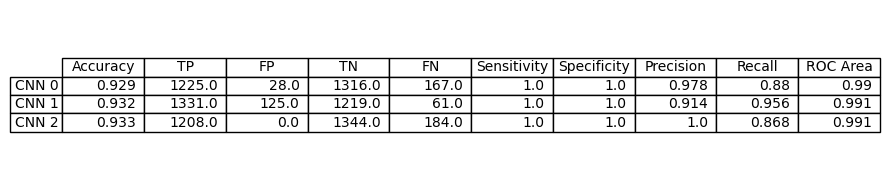

In [26]:
metrics = np.asarray(metric_list).reshape(3, 10).round(3)


fig, ax = plt.subplots(figsize=(9, 2))

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

rows = ["CNN 0", "CNN 1", "CNN 2"]
table = ax.table(metrics, colLabels=metric_labels, rowLabels=rows, loc='center')

table.auto_set_font_size(False)

fig.tight_layout()

plt.show()